## Simple PySpark example: F-1 results
How to read, join and aggregate data in CSV files using Spark SQL.  
- Kaggle datase "[Formula 1 Race Data](https://www.kaggle.com/cjgdev/formula-1-race-data-19502017)" is used 
  - download extract the zip file
  - place file to a location visible from the container and set relative file locations of `spark.read.csv()`
- We would like to know which drivers spent the most time racing, and check distribution of the aggregated race times of the drivers. 

In [1]:
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split
import timeit 

findspark.init()

spark = SparkSession.builder \
    .appName('PySpark local test') \
    .config('spark.default.parallelism', 5).config('spark.executor.memory', '4G').config('spark.driver.memory', '5G') \
    .getOrCreate()

### Define relevant CSV data sources

In [2]:
drivers_df = spark.read.csv("../../formula-1-race-data/drivers.csv", header=True, encoding="latin1")
drivers_df.createOrReplaceTempView("drivers")
#drivers_df.printSchema()
drivers_df.show(5)

+--------+----------+------+----+--------+----------+----------+-----------+--------------------+
|driverId| driverRef|number|code|forename|   surname|       dob|nationality|                 url|
+--------+----------+------+----+--------+----------+----------+-----------+--------------------+
|       1|  hamilton|    44| HAM|   Lewis|  Hamilton|07/01/1985|    British|http://en.wikiped...|
|       2|  heidfeld|  null| HEI|    Nick|  Heidfeld|10/05/1977|     German|http://en.wikiped...|
|       3|   rosberg|     6| ROS|    Nico|   Rosberg|27/06/1985|     German|http://en.wikiped...|
|       4|    alonso|    14| ALO|Fernando|    Alonso|29/07/1981|    Spanish|http://en.wikiped...|
|       5|kovalainen|  null| KOV|  Heikki|Kovalainen|19/10/1981|    Finnish|http://en.wikiped...|
+--------+----------+------+----+--------+----------+----------+-----------+--------------------+
only showing top 5 rows



In [3]:
lap_times_df = spark.read.csv("../../formula-1-race-data/lapTimes.csv", header=True)      # 2.1 GB file, 1.419.607 lines
lap_times_df.createOrReplaceTempView("lap_times") 
lap_times_df.show(5)

+------+--------+---+--------+--------+------------+
|raceId|driverId|lap|position|    time|milliseconds|
+------+--------+---+--------+--------+------------+
|   841|      20|  1|       1|1:38.109|       98109|
|   841|      20|  2|       1|1:33.006|       93006|
|   841|      20|  3|       1|1:32.713|       92713|
|   841|      20|  4|       1|1:32.803|       92803|
|   841|      20|  5|       1|1:32.342|       92342|
+------+--------+---+--------+--------+------------+
only showing top 5 rows



### Sum up lap times of drivers
- project on relevant columns, group by driverId, sum times in milliseconds
- draw histogram of times
- filter drivers over 100 hours
- add time values in hours

In [4]:
times_sum_df = spark.sql("""
select t.driverId, sum(t.milliseconds) as milliseconds_sum, sum(t.milliseconds)/(1000*60*60) as hours_sum
from   lap_times t
group by t.driverId
order by sum(t.milliseconds) desc
""")

times_sum_df.createOrReplaceTempView("times_sum")
times_sum_df.show(5)

+--------+----------------+------------------+
|driverId|milliseconds_sum|         hours_sum|
+--------+----------------+------------------+
|      18|   1.556614792E9| 432.3929977777778|
|       4|   1.513292145E9|420.35892916666666|
|      13|    1.42968693E9|397.13525833333335|
|      22|    1.34170681E9| 372.6963361111111|
|       8|   1.328518217E9|369.03283805555554|
+--------+----------------+------------------+
only showing top 5 rows



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94c6b5deb8>]],
      dtype=object)

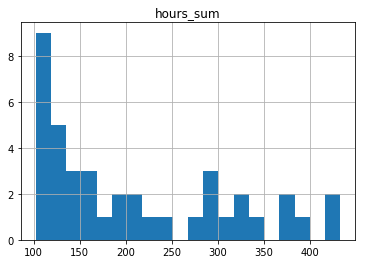

In [8]:
# we use the toPandas() function as the easiest way to draw histograms (the same as with the Pandas example)
times_sum_df.toPandas().hist(column='hours_sum', bins=20)

### Join driver data
filter on hours over 100, and display toplist as a barchart 

In [9]:
times_sum_df = spark.sql("""
select d.driverId, d.code, d.driverRef, d.forename, d.surname, t.hours_sum
from   times_sum t
         inner join drivers d on d.driverId = t.driverId
where t.hours_sum >= 100
order by hours_sum desc
""")

times_sum_df.createOrReplaceTempView("times_sum")
times_sum_df.show(5)

+--------+----+-----------+--------+-----------+------------------+
|driverId|code|  driverRef|forename|    surname|         hours_sum|
+--------+----+-----------+--------+-----------+------------------+
|      18| BUT|     button|  Jenson|     Button| 432.3929977777778|
|       4| ALO|     alonso|Fernando|     Alonso|420.35892916666666|
|      13| MAS|      massa|  Felipe|      Massa|397.13525833333335|
|      22| BAR|barrichello|  Rubens|Barrichello| 372.6963361111111|
|       8| RAI|  raikkonen|    Kimi|RÌ_ikkÌ¦nen|369.03283805555554|
+--------+----+-----------+--------+-----------+------------------+
only showing top 5 rows



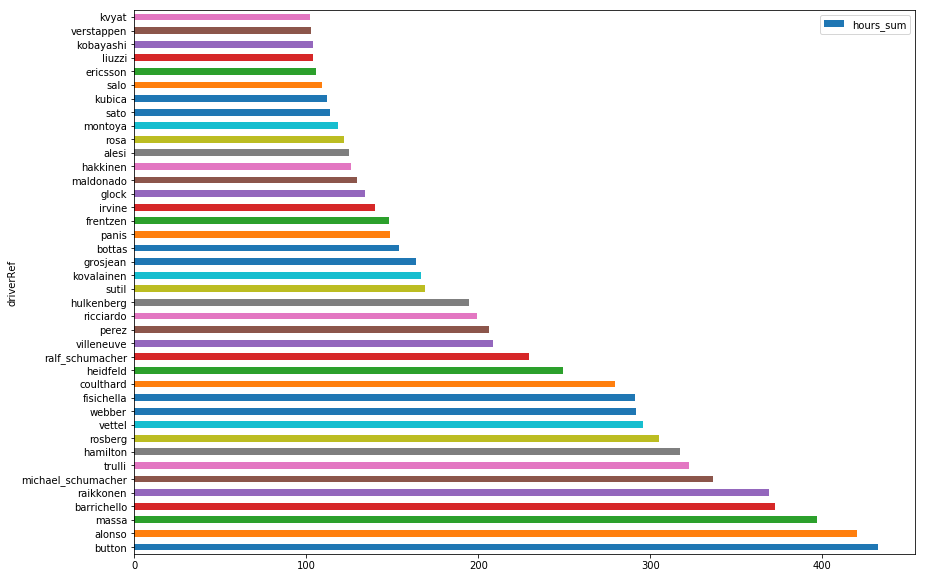

In [7]:
times_sum_df.toPandas().plot.barh(y='hours_sum', x='driverRef', figsize=(14,10))